In [286]:
import random
import pandas as pd
import numpy as np
import copy
import networkx as nx
import matplotlib.pyplot as plt
import json as js
from scipy.stats import truncnorm
import seaborn as sns
sns.set_style({'axes.facecolor': 'white',
         'axes.edgecolor': 'black',
        'axes.grid': False,
        'axes.spines.right': False,
        'axes.spines.top': False,
        'figure.facecolor':"white",
        'axes.labelcolor': '.15',
         'grid.color': 'white',
         'grid.linestyle': '-',
         'text.color': '.15',
         'xtick.color': '.15',
         'ytick.color': '.15',
        'patch.edgecolor': 'white',})

In [287]:
n = 1000
m = 4000
def constrained_sum_sample_pos(n, m):
    dividers = sorted(random.sample(range(1, m), n - 1))
    return [a - b for a, b in zip(dividers + [m], [0] + dividers)]

def random_graph_revised(n, m):
    degree_squence = constrained_sum_sample_pos(n, m)
    node_ids = list(range(n))
    edge_list = []
    for i in node_ids:
        non_self = [j for j in node_ids if i!= j]
        targets = random.sample(non_self, degree_squence[i]) 
        edges_of_n = [(i,target) for target in targets]
        edge_list = edge_list+ edges_of_n
    G = nx.DiGraph()
    G.add_edges_from(edge_list)
    return G

G = random_graph_revised(n, m)

In [288]:
### social media 
class SocialMedia:
    def __init__(self, n = 100, m = 400):
        self.p = .5
        #self.q = .5
        self.n = n
        self.m = m
        self.l = np.random.randint(2, 10, n)
        self.G = random_graph_revised(self.n,self.m) 
        ### need to make sure there is no node that has zero out degree. 
        
        self.O = np.random.uniform(-1, 1, self.n)
        self.Opinions_db = {"Time_0": copy.deepcopy(self.O)}#pd.DataFrame(self.O, columns= ["Time_0"]) ### uniform distribution
        self.Message_db = pd.DataFrame(columns = ["original_poster", "rt_poster","content", "rt_status"])
        self.Network_db = {"Time_0": list(self.G.edges())}
        self.ME_db = pd.DataFrame(columns = ["uid", "Time", "index", "effects"])
        self.Config_db = {}
        #self.audience = audience
        #self.media_id = ["mainstream_media", "liberal_media", "conservative_media", "extreme_liberal_media", "extreme_conservative_media"]
    #def record_sub(self, media_id, media_audience):
        #return media_audience 
    
    def screen_size(self, uid):
        l = self.l[uid] + np.random.randint(-2, 2) ## hidden parameter
        return l
            
    def make_screen(self, uid, l, sub, include_media = True):
        friends = list(self.G.successors(uid))
        if include_media :
            friends = friends + sub
        #print
        repost_by_friend = self.Message_db.rt_poster.isin(friends)
        #print(repost_by_friend)
        screen = self.Message_db[repost_by_friend].tail(l)
        if len(screen)>0:
            return screen
        else:
            return None
        
    def get_recent_o(self, uid):
        return self.O[uid]

    def get_recent_neighors(self, uid):
        return self.G.successors(uid)
    
    def get_recomm_friends(self, uid, media_ids, eta):
        me_and_friends = set(self.G.successors(uid)).union({uid}).union(media_ids)
        recent = self.Message_db[~self.Message_db.rt_poster.isin(me_and_friends)].tail(self.l[uid]*3) ### hidden parameter
        if len(recent) >0:
            recent["fri_or_foe"] = np.where(np.abs(recent.content.values-self.O[uid]) < eta, True, False)
            recommended = recent[recent.fri_or_foe == True]
            if len(recommended) > 0:
                return recommended


    def add_edge(self, uid, target):
        self.G.add_edge(uid, target)

    def delete_edge(self, uid, target):
        self.G.remove_edge(uid, target)
        
    def add_message(self, messege):
        self.Message_db = pd.concat([self.Message_db,messege], ignore_index = True, axis = 0)
    #########    
    def update_Opinions_db(self, uid, new_o, t):
        if new_o:
            self.O[uid] = new_o
        self.Opinions_db["Time_"+str(t+1)] = copy.deepcopy(self.O)
        #self.Opinions_db = pd.concat([self.Opinions_db, pd.DataFrame(self.O, columns= ["Time_"+str(t)])], axis =1 )

    def update_Network_db(self, t):
        self.Network_db["Time_"+str(t+1)] = copy.deepcopy(list(self.G.edges())) 
    
    def update_ME_db(self,t, uid, fri, foe):
        if fri is not None:
            #print(fri)
            fri = fri.reset_index()
            fri["effects"] = True 
            fri["uid"] = uid
            fri["Time"] = t + 1
            fri_record = fri[["uid", "Time", "index", "effects"]]
            #print(fri_record)
            self.ME_db = pd.concat([self.ME_db, fri_record], axis= 0, ignore_index=True)
            #print(self.ME_db)
        if foe is not None:
            foe = foe.reset_index()
            foe["effects"] = False
            foe["uid"] = uid
            foe["Time"] = t + 1 
            foe_record = foe[["uid", "Time", "index", "effects"]]
            self.ME_db = pd.concat([self.ME_db, foe_record], ignore_index= True)
        #return fri_record, foe_record
        
    def find_media(self, screen):
        if screen is not None:
            bool = (screen.original_poster.str.contains("media") | screen.rt_poster.str.contains("media"))
            found = screen[bool]
            return found
           

In [289]:
class User():
    def __init__ (self, uid, eta, miu, o, G, media_dict):
        self.uid = uid
        #self.p = .5
        #self.q = q
        self.eta = eta
        self.miu= miu
        #self.screen = screen
        self.o = o
        self.G = G
        self.f = self.G.successors(uid) 
        self.media_ids = list(media_dict.keys()) #["mainstream_media", "liberal_media", "conservative_media", "extreme_liberal_media", "extreme_conservative_media"]
        self.sub = [v.id for k, v in media_dict.items() if uid in v.audience]


    def find_fri(self, screen):
        if screen is not None:
            screen["fri_or_foe"] = np.where(np.abs(screen.content.values-self.o)<self.eta, True, False)
            fri = screen[screen.fri_or_foe == True]
            if len (fri) >0:
                return fri
            else:
                return None
    
    def find_foe(self, screen):
        if screen is not None:
            screen["fri_or_foe"] = np.where(np.abs(screen.content.values-self.o)<self.eta, True, False)
            foe = screen[screen.fri_or_foe == False]
            if len (foe) >0:
                return foe
            else:
                return None
 
    def update_opinion(self,fri, rand):
        if fri is not None:
            social_influence = self.miu * np.mean(fri.content - self.o)
            new_opinion = self.o+ social_influence + (np.random.random()*2-1)*rand
            ##self.o = new_opinion >>> this is somewhat critical: including this that means all of posts, friending, and unfriending will based on the new opinion
            return new_opinion

    def generate_post(self, fri, p = .5):
        if np.random.random()< p:
            if fri is not None:
                rt = fri.sample(1)
                rt["rt_poster"] = self.uid
                rt["rt_status"] = True
                rt.drop(["fri_or_foe"], axis = 1, inplace = True)
                #print("Agent {} repost {}".format(str(self.uid), str(rt.original_poster)))
                return rt    
        else:
            self_tw = pd.DataFrame({"original_poster": [self.uid], "rt_poster": [self.uid], "content": [self.o], "rt_status":[False]})
            #print("Agent {} post about self".format(str(self.uid)))
            return self_tw
    
    def friend_random(self):
        #print(me_and_friends) 
        #if np.random.random()< self.p:
        me_and_friends = set(self.f).union({self.uid})#.union(self.media_id)
        non_friends = set(self.G.nodes) - me_and_friends
        target = int(np.random.choice(list(non_friends)))
        self.G.add_edge(self.uid, target)
        return True
    
    def friend_repost(self,screen): #fri):
        #f = copy.copy(self.f)
        #if np.random.random()< self.p:
        if screen is not None:
            me_and_friends_media = set(self.f).union({self.uid}).union(self.media_ids)
            original_posters = set(screen.original_poster.values)- me_and_friends_media
            if len(original_posters) >0:
                target = int(np.random.choice(list(original_posters)))
                self.G.add_edge(self.uid, target)
                return True
        
    def friend_recommend(self, recommend):
        #if np.random.random() < self.p:
        if recommend is not None:
            target = int(recommend.rt_poster.sample(1))
            #print("Agent {} followed {}".format(str(self.uid, target)))
            self.G.add_edge(self.uid, target)
            return True
        
    def unfriend(self, foe):
        #if np.random.random()<self.p:
        if foe is not None:
            foe = foe[~foe["rt_poster"].isin(self.media_ids)]
            if len(foe)>0:
                target_foe = int(foe["rt_poster"].sample(1))
                #print("Agent {} unfollowed {}".format(str(self.uid, target_foe)))
                self.G.remove_edge(self.uid, target_foe)
                self.f = self.G.successors(self.uid) 
                #print("Deleted ({},{})".format(str(self.uid),str(target_foe)))
                return True
            
            



In [443]:
def decomposition(s, n):
    holder = np.ones(s)
    loc = [0] +list(sorted(np.random.choice(np.arange(1, s), n-1, replace=False))) + [s]
    print(loc)
    vals = [np.sum(holder[loc[i]:loc[i +1]]) for i in range(len(loc)-1)]
    return vals
decomposition(7, 3)


[0, 1, 2, 7]


[1.0, 1.0, 5.0]

In [464]:
class MassMedia():
    def __init__(self, n, p,  s):
        self.p = p
        self.s = s
        self.n = n
        self.media_ids = ["m" + str(i) for i in range(n)]
        self.share_init = self.init_share()
        self.share = {self.media_ids[i]: self.share_init[i] for i in range(self.n)}
        
        #self.audience = np.random.choice(np.arange(n), int(np.floor(n*s)), replace = False)
        #self.meta = {"c{}p{}s{}".format(str(c).strip("."), str(p).strip("."), str(s).strip(".")): self.audience}

    def init_share(self):
        holder = np.ones(self.s)
        loc = [0] +list(sorted(np.random.choice(np.arange(1, self.s), self.n-1, replace=False))) + [self.s]
        vals = [int(np.sum(holder[loc[i]:loc[i +1]])) for i in range(len(loc)-1)]
        return vals

    def media_message(self, mid, d = .25):
        #d = .3
        if np.random.rand() < self.p:
            v = self.c + d*(np.random.rand()*2 -1)
            post = pd.DataFrame({"original_poster": [mid], "rt_poster": [mid], "content": [v], "rt_status":[False]})
            return post
        else:
            return None

test = MassMedia(3, .5, 100)
test.share

{'m0': 6, 'm1': 63, 'm2': 31}

In [291]:
#def media_at_t(sm, t):
        #sm.add_message(mass_media.liberal_media(t-1))
        #sm.add_message(mass_media.conservative_media(t-1))
#def evaluate_screen(sm, user, screen_size,include_media=True):
    #o= sm.get_recent_o(user.uid)
    #screen = sm.make_screen(user.uid, l = screen_size, include_media = include_media)
    #fri = user.find_fri(screen)
    #foe = user.find_foe(screen)
    ##
    #new_o = user.update_opinion(fri)
    #new_post = user.generate_post(fri)
    #return new_o, new_post, fri, foe

def unfriend_friend(prob_rewire, user, fri, foe, sm, media_ids):
    q = np.random.random()
    if q< prob_rewire:
        unfriend = user.unfriend(foe)
        if unfriend == True:
            #print(str(user.uid), "unfriend a foe")
            new_friend = user.friend_repost(fri)
            if new_friend != True:
                #print(str(user.uid), "did not find a repost friend")
                recommend = sm.get_recomm_friends(user.uid, media_ids, user.eta)
                new_friend = user.friend_recommend(recommend)
                if new_friend != True:
                    #print(str(user.uid), "did not find a repost nor recommend friend")
                    new_friend = user.friend_random()
                    if new_friend != True:
                        print(str(user.uid), "Warning: NOT finding a random/repost/recommend friend")
                        
                #else:
                    #

#def mass_media_project(c, sm, t, para_list):
    
        #sm.add_message(mass_media.any_media(t, n2))                    

def sim(T, eta, miu, prob_rewire, rand, media_para, include_media = True, effect_record = True, n = 100, m = 400):  #rand,
    sm = SocialMedia(n= n, m = m)
    media_dict = {media_para[num]["id"]: MassMedia(c = media_para[num]["c"], 
                            p =  media_para[num]["p"], 
                            s =  media_para[num]["s"], 
                            id = media_para[num]["id"])
                            for num in media_para.keys()}
    media_ids = list(media_dict.keys())
    for k in media_ids:
        sm.Config_db[k] = media_dict[k].audience.tolist()
    for t in np.arange(T):
        if include_media == True:
            for k in media_ids:
                #print(med_ms)
                ms = media_dict[k].media_message()
                if ms is not None:
                    sm.add_message(ms)       
        uid = np.random.randint(sm.n)
        l = sm.screen_size(uid)
        #print(l)
        if l == 0:
            pass
        else:
            o = sm.get_recent_o(uid)
            user = User(uid, eta, miu, o, sm.G, media_dict)
            screen = sm.make_screen(user.uid, l, user.sub, include_media = include_media)
            fri = user.find_fri(screen)
            foe = user.find_foe(screen)
            #print(fri)
            #print("XXXXXXX")
            ##
            new_o = user.update_opinion(fri, rand = rand)
            new_post = user.generate_post(fri)
            unfriend_friend(prob_rewire, user, fri, foe, sm, media_ids)
            sm.add_message(new_post)
            ##
            sm.update_Opinions_db(uid, new_o, t)
            sm.update_Network_db(t)
            if effect_record == True:
                sm.update_ME_db(t, uid, fri, foe)
    return sm#

In [353]:
eta = .5
miu = .3
#l = 7
q  = .3
#c = 100
T = 10000
rand = .25
media_para = {1:{"c":0,  "p": .1, "s": .1, "id":"c0p01s01"} }
#media_para = {1:{"c":.0, "p": .2, "id":"mainstream_media" }, 
       #       2:{"c":-1, "p": .1, "id":"extreme_conservative_media" } }

n = 100
m = 400

In [360]:
sm = sim(T =T , eta = eta, miu= miu, prob_rewire = q,
         media_para = media_para, rand = rand, 
         include_media = False, effect_record= False, n = n, m = m)

In [322]:
for i in range(2): 
    with open("test.txt", "a+") as f:
        js.dump({i: sm.Config_db}, f)
        f.write("\n")

In [324]:
with open("test.txt", "r") as f:
    for i in f.readlines():
        test= js.loads(i)
        print(test)

{'0': {'c0p01s01': [76, 68, 22, 63, 86, 94, 51, 54, 3, 49]}}
{'1': {'c0p01s01': [76, 68, 22, 63, 86, 94, 51, 54, 3, 49]}}


Text(0.5, 0.95, 'Baseline')

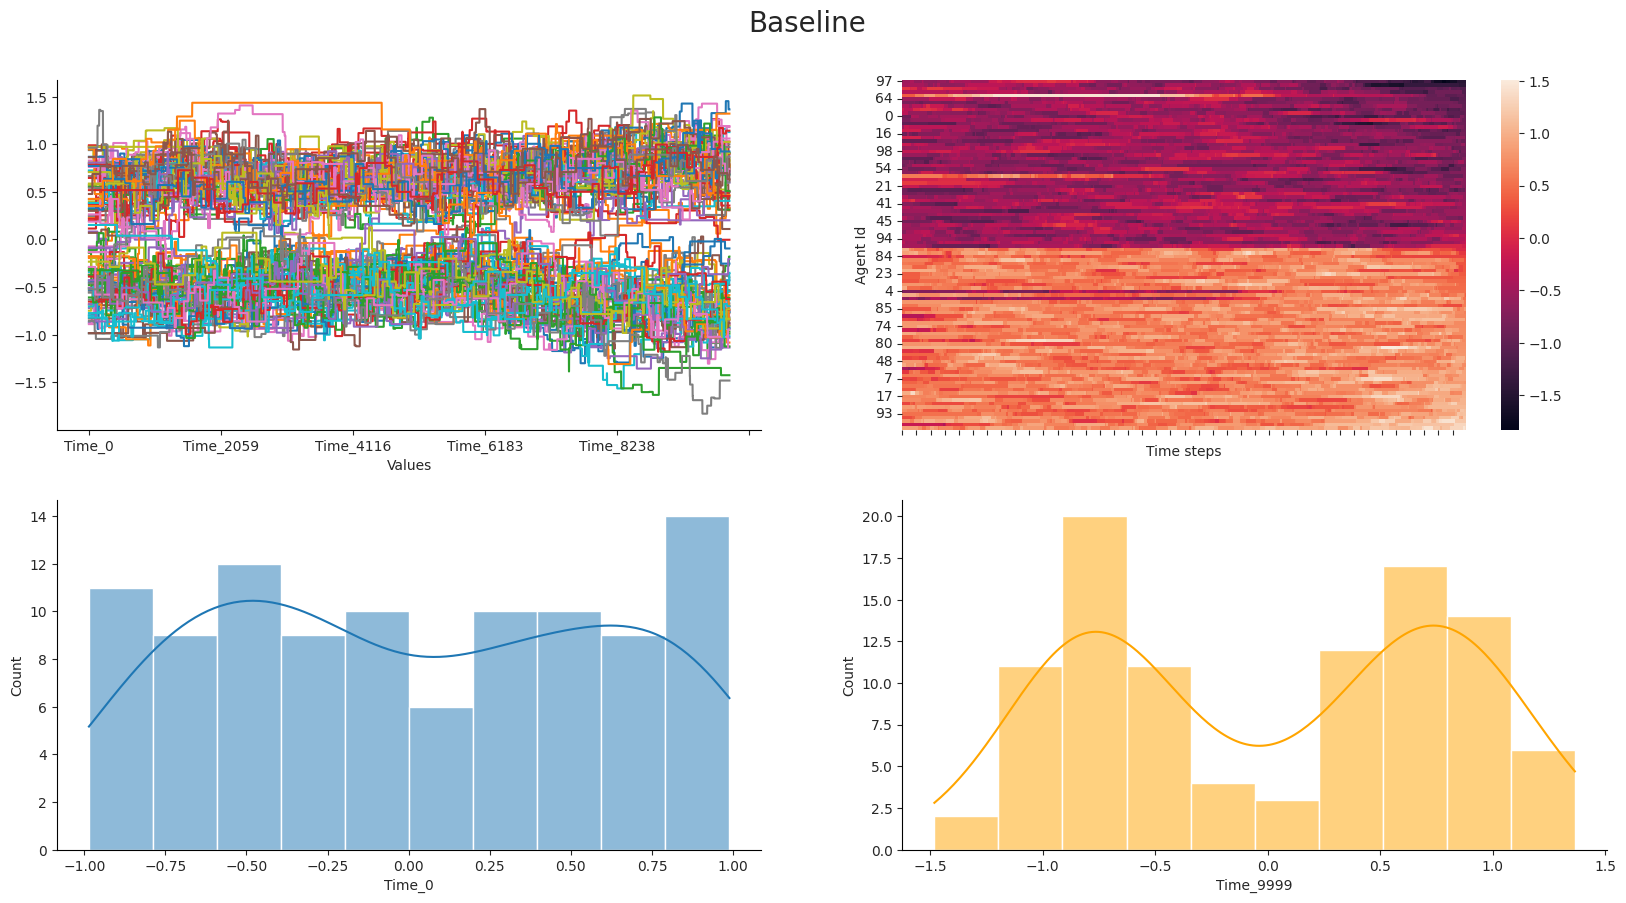

In [361]:
fig, axes = plt.subplots(2, 2, figsize = (10, 10))
axes = axes.flatten()
pd.DataFrame(sm.Opinions_db).T.plot(figsize = (20,10), ax = axes[0])
axes[0].legend().remove()
axes[0].set_xlabel("Values")
sns.heatmap(pd.DataFrame(sm.Opinions_db).sort_values(by = "Time_{}".format(str(T-1))), ax = axes[1])
#axes[1].set_title("Baseline", fontsize = 26)
axes[1].set_ylabel("Agent Id")
axes[1].set_xlabel("Time steps")
#axes[1].set_xticks(np.arange(10))
axes[1].set_xticklabels([])
#axes[1].set_title("Baseline Consensus", fontsize = 26)
sns.histplot(pd.DataFrame(sm.Opinions_db)["Time_0"], bins = 10, ax = axes[2], kde= True)
sns.histplot(pd.DataFrame(sm.Opinions_db)["Time_{}".format(str(T-1))], bins = 10, ax = axes[3], kde = True, color = "orange")
plt.suptitle("Baseline", y = .95, fontsize = 20)

#ax.set_title("eta = {}, T/c = {}, condition = Polarized".format(str(eta), str(np.around(T/c,2))))


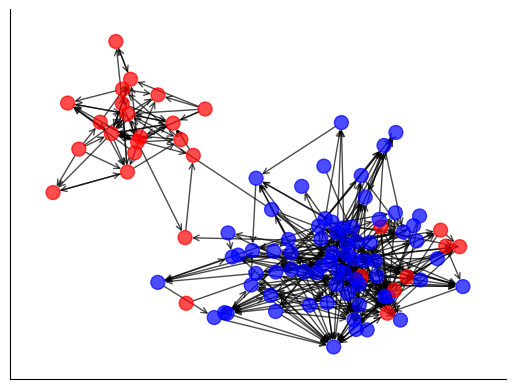

In [359]:
G= nx.from_edgelist(sm.Network_db["Time_{}".format(str(T-1))], create_using= nx.DiGraph)
pos = nx.spring_layout(G,  k = .4, iterations= 70)
nodes_color = np.where(pd.DataFrame(sm.Opinions_db).T.loc["Time_{}".format(str(T-1))][list(G.nodes)] >.55, "red", "blue")
nx.draw_networkx(G, pos = pos, alpha =.7, arrowstyle = "->", with_labels = False, node_size = 100, node_color = nodes_color)


In [148]:
sm.ME_db[sm.ME_db.effects == True]

,uid,Time,index,effects
1,6,7,3,True
2,9,10,6,True
3,17,12,5,True
4,17,12,6,True
6,62,22,12,True
...,...,...,...,...
54133,81,10000,10240,True
54134,81,10000,10241,True
54135,81,10000,10260,True
54136,81,10000,10283,True


In [149]:
pd.merge(sm.ME_db, sm.Message_db.reset_index(), on="index", how = "left")

,uid,Time,index,effects,original_poster,rt_poster,content,rt_status
0,52,6,1,False,mainstream_media,mainstream_media,-0.167275,False
1,6,7,3,True,63,63,-0.477246,False
2,9,10,6,True,15,15,-0.182823,False
3,17,12,5,True,63,6,-0.477246,True
4,17,12,6,True,15,15,-0.182823,False
...,...,...,...,...,...,...,...,...
54133,81,10000,10240,True,mainstream_media,50,0.231273,True
54134,81,10000,10241,True,86,86,-0.040569,False
54135,81,10000,10260,True,90,50,-0.153949,True
54136,81,10000,10283,True,86,86,-0.190864,False


In [135]:
name = "e5m3base"
sm.Opinions_db.to_csv(os.getcwd() + "/data/baseline/"+ name + "_opinion.csv")
#sm.Network_db.to_csv(os.getcwd() + "data/baseline/e5m3base.csv")
pd.DataFrame(sm.Network_db).to_csv(os.getcwd() + "/data/baseline/"+ name + "_network.csv")
sm.ME_db.to_csv(os.getcwd() + "/data/baseline/"+ name + "_me.csv")
    #sm.Message_db.to_csv(os.getcwd() + "/data/baseline/"+ name + "_message.csv")

In [35]:
#for c in np.linspace()
#sm = sim(T =T , eta = eta, miu= miu, prob_rewire = q, c = c, screen_size = l, mass_media_para = media_para, include_media= False, effect_record= True)
#media_para= [(40,60)]
rep = 10
for r in range(rep):
    name = "rep_" + str(r) + "/"
    new_dic = os.makedirs("./polarized2/"+name)
    for c in range(1, 100):
        sm = sim(T =T , eta = eta, miu= miu, prob_rewire = q, c = c, screen_size = l, mass_media_para = media_para, include_media =True, effect_record= True)
        #ms_e5m3[c] = sm
        #name = "e5m3c{}mainstream".format(str(c))
        sm.Opinions_db.to_csv("./polarized2/"+name+"c{}_opinion.csv".format(str(c)))
        #sm.Network_db.to_csv(os.getcwd() + "data/baseline/e5m3base.csv")
        pd.DataFrame(sm.Network_db).to_csv("./polarized2/"+name+"c{}_newtork.csv".format(str(c)))
        sm.ME_db.to_csv("./polarized2/"+name+"c{}_effect.csv".format(str(c)))
        sm.Message_db.to_csv("./polarized2/"+name+"c{}_message.csv".format(str(c)))

KeyboardInterrupt: 

In [347]:
from tqdm import tqdm
paras = list(permutations(np.arange(1, 10, 2)/10, 2))
c = 0
for para in tqdm(paras):
    if para in [(0.1, 0.1), (0.1, 0.5), (0.1, 0.9), (0.5, 0.1), (0.9, 0.1)]:
        pass
    else:
        p, s = para
        print(p,s)

100%|██████████| 20/20 [00:00<00:00, 56987.83it/s]

0.1 0.3
0.1 0.7
0.3 0.1
0.3 0.5
0.3 0.7
0.3 0.9
0.5 0.3
0.5 0.7
0.5 0.9
0.7 0.1
0.7 0.3
0.7 0.5
0.7 0.9
0.9 0.3
0.9 0.5
0.9 0.7


In [330]:
str(0.1)A.strip("0.")

'1'

In [190]:
with open("test.json", "w") as f:
        js.dump(sm.Network_db, f)

In [23]:
sm.Message_db.original_poster.value_counts()

64    235
36    214
33    198
4     177
49    175
     ... 
17     46
66     44
65     43
68     39
60     38
Name: original_poster, Length: 100, dtype: int64

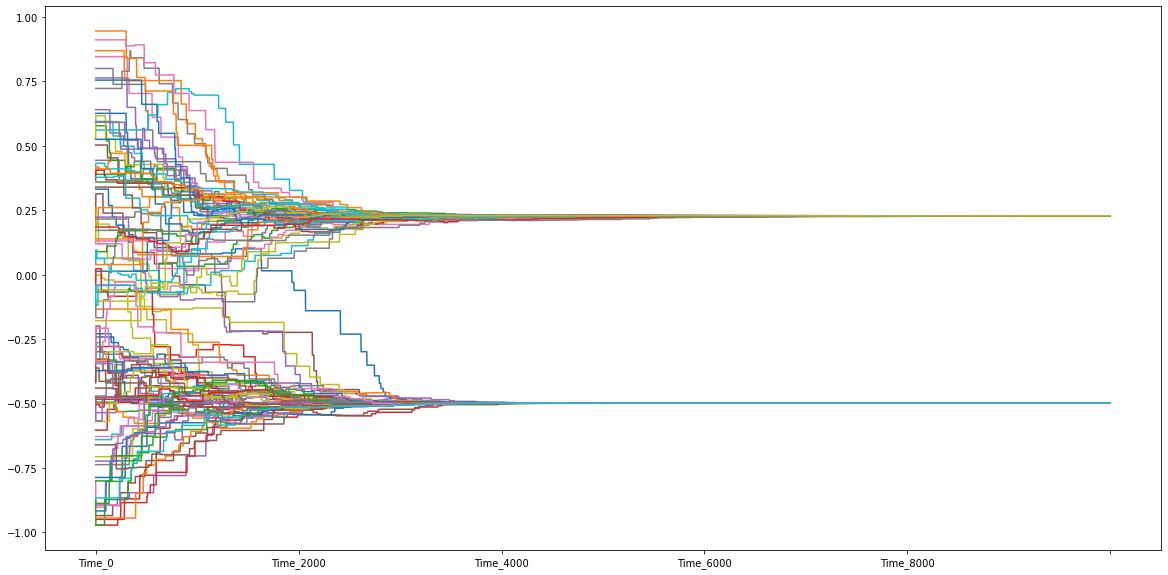

In [25]:
ax = sm.Opinions_db.T.plot(figsize = (20,10))
ax.legend().remove()

In [112]:
import json as js, os

In [50]:
dir = "/Volumes/GoogleDrive/My Drive/sim_media_effects"
#filename1 = os.listdir(data_dir)

In [56]:
len(np.floor(np.linspace(1, 300)))

50

In [182]:
Harreta = .6,
miu = .3
q = .3
T =10000
l = 7
c = 50
rep = 10
media_para = [(0, 20), (20, 40), (40,60), (60, 80), (80, 100)]
dir = "/Volumes/GoogleDrive/My Drive/sim_media_effects/five_media/"
for i in np.arange(3, rep):
    data_dir = dir+ "rep_"+str(i)
    os.makedirs(data_dir)
    for c in np.floor(np.linspace(1, 300)):
        c = int(c)
        #os.makedirs(data_dir+"\\Network\\")
        #os.makedirs(data_dir+"\\Message\\")
        #os.makedirs(data_dir+"\\ME\\")
        sm = sim(T =T , eta = eta, miu= miu, prob_rewire = q, c = c, screen_size = l, mass_media_para = media_para, effect_record= True)
        #ms_e5m3[c] = sm
        sm.Opinions_db.to_csv(data_dir +"/Opinion_c{}.csv".format(str(c)))
        sm.Message_db.to_csv(data_dir +"/Message_c{}.csv".format(str(c)))
        sm.ME_db.to_csv(data_dir +"/ME_c{}.csv".format(str(c)))
        #network_dir = data_dir +"\\Network\\"
        with open(data_dir + "/Network_c{}.json".format(str(c)), "w") as f:
            js.dump(sm.Network_db, f)
    #break

KeyboardInterrupt: 

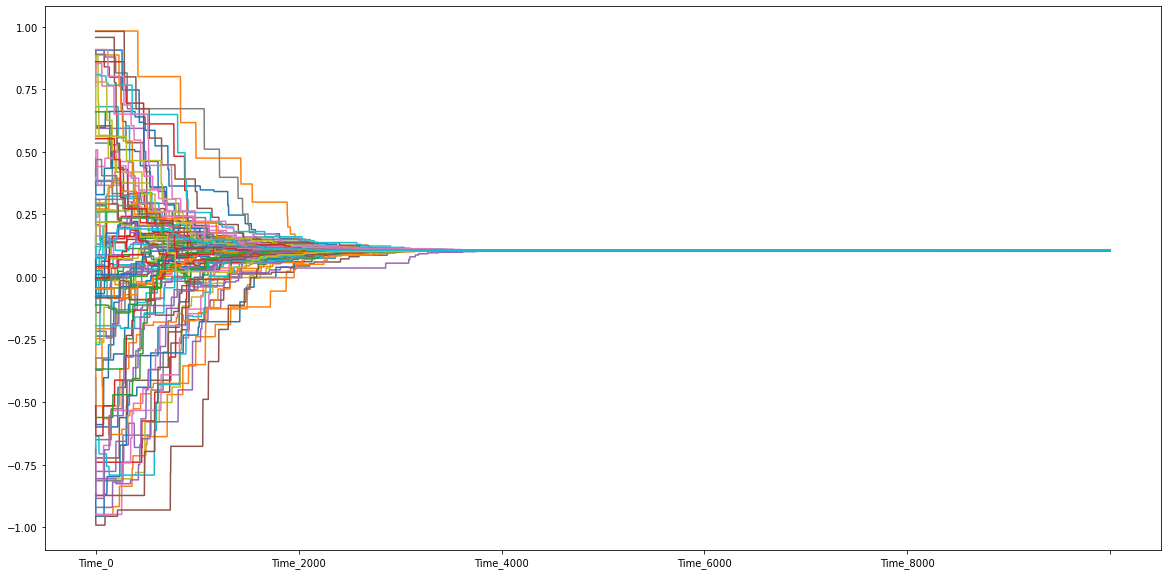

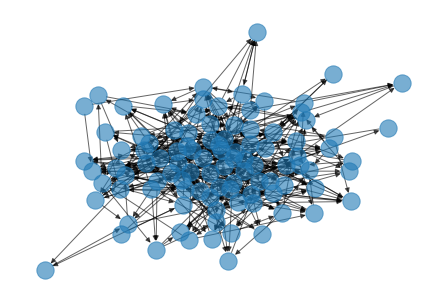

In [34]:
G= nx.from_edgelist(sm.Network_db["Time_0"], create_using= nx.DiGraph)
nx.draw(G, alpha = 0.6)

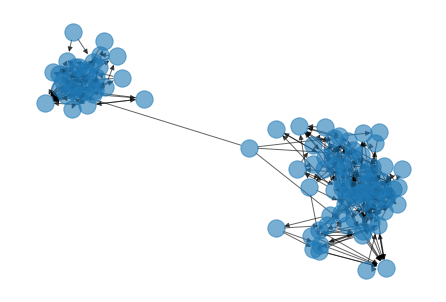

In [39]:
G = nx.from_edgelist(sm.Network_db["Time_9999"], create_using= nx.DiGraph)
pos = nx.spring_layout(G, k=0.15, iterations= 40)
#pos = nx.spiral_layout(G, eq)
nx.draw(G, pos = pos, alpha = 0.6)

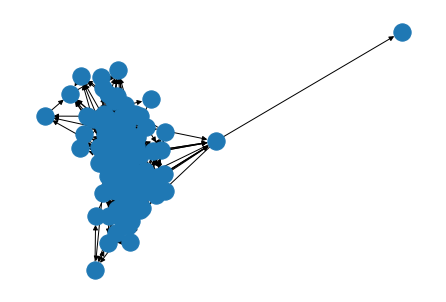

In [118]:
test = nx.from_edgelist(sm.Network_db["Time_9000"], create_using= nx.DiGraph)
nx.draw(test)

In [49]:
test = nx.from_edgelist(sm.Network_db["Time_0"], create_using= nx.DiGraph)
len(test.edges())

400

In [161]:
sm.make_screen(20, l = 7, include_media = True).reset_index()

,index,original_poster,rt_poster,content,rt_status
0,886,mass_media,mass_media,0.065294,False
1,894,mass_media,mass_media,0.066234,False
2,896,43,43,0.881775,False
3,902,52,52,0.086205,False
4,904,mass_media,mass_media,0.066627,False
5,915,mass_media,mass_media,0.066648,False
6,920,19,19,0.075204,False


In [18]:
parameters = np.around(np.linspace(0,1, 50), 2)
#MIU = np.linspace(0,1, 20)Q = np.linspace(0,1, 20)
T = 10000
reptition = 10
#q  = .3

In [158]:
sm.ME_db

,message_index,uid,fri_or_foe


In [126]:
screen.index

Int64Index([0, 0, 0, 0, 0, 0, 0], dtype='int64')

In [ ]:
class MassMedia():
    def __init__(self, cycle, P):
        self.c = cycle
        
    def mass_media_messege(self, c, ):
        res = t % self.c
        if res == 0:
            time = "Time_{}".format(str(t-1))
            media_content = np.mean(self.O[time])
            post = pd.DataFrame({"original_poster": ["mainstream_media"], "rt_poster": ["mainstream_media"], "content": [media_content], "rt_status":[False]})
            return post
    
    def liberal_media(self, t):
        res = t % self.c
        if res == 0:
            time = "Time_{}".format(str(t-1))
            media_content = np.quantile(self.O[time], .10)
            post = pd.DataFrame({"original_poster": ["liberal_media"], "rt_poster": ["liberal_media"], "content": [media_content], "rt_status":[False]})
            return post
        
    def conservative_media(self, t):
        res = t % self.c
        if res == 0:
            time = "Time_{}".format(str(t-1))
            media_content = np.quantile(self.O[time], .90)
            post = pd.DataFrame({"original_poster": ["conservative_media"], "rt_poster": ["conservative_media"], "content": [media_content], "rt_status":[False]})
            return post
        
    def any_media(self, t, n):
        if n <20:
            lab = "extreme_liberal_media"
        elif n<40:
            lab = "liberal_media"
        elif n< 60:
            lab = "mainstream_media"
        elif n<80:
            lab = "conservative_media"
        else:
            lab = "extreme_conservative_media"
        res = t % self.c
        if res == 0:
            time = "Time_{}".format(str(t-1))
            media_content = np.percentile(self.O[time], n)
            post = pd.DataFrame({"original_poster": [lab], "rt_poster": [lab], "content": [media_content], "rt_status":[False]})
            return post

    def random_media(self, t, m=0, sd = .3):
        res = t % self.c
        if res == 0:
            v = np.random.choice(np.random.normal(m, sd, 1000))
            if v <-1:
                v = -1
            if v >1:
                v = 1
            if v <-.6:
                lab = "extreme_liberal_media"
            elif v<-.2:
                lab = "liberal_media"
            elif v< .2:
                lab = "mainstream_media"
            elif v<.6:
                lab = "conservative_media"
            else:
                lab = "extreme_conservative_media" 
            post = pd.DataFrame({"original_poster": [lab], "rt_poster": [lab], "content": [v], "rt_status":[False]}) 
            return post  